In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:

market_research = pd.read_csv('market_research.csv')
customer_interactions = pd.read_csv('customer_interactions.csv')

In [4]:
# Aggregate Interaction Data
customer_interactions['InteractionDate'] = pd.to_datetime(customer_interactions['InteractionDate'])

# InteractionCount Feature
interaction_counts = customer_interactions.groupby('CustomerID').size().rename('InteractionCount')

# Recency Feature (days since last interaction)
latest_interaction = customer_interactions.groupby('CustomerID')['InteractionDate'].max()
recency = (datetime.now() - latest_interaction).dt.days.rename('Recency')

# PreferredChannel Feature
preferred_channel = customer_interactions.groupby('CustomerID')['Channel'].agg(
    lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
).rename('PreferredChannel')

# AvgResolutionTime Feature
avg_resolution_time = customer_interactions.groupby('CustomerID')['ResolutionTime'].mean().rename('AvgResolutionTime')

# Combine Interaction Features
interaction_features = pd.concat([interaction_counts, recency, preferred_channel, avg_resolution_time], axis=1)

In [5]:
# Merge those Features with Market Research Data
data = pd.merge(market_research, interaction_features, on='CustomerID', how='left')

# Handle Missing Values with average values in some cases
data['SatisfactionScore'].fillna(data['SatisfactionScore'].median(), inplace=True)
data['RecommendationLikelihood'].fillna(data['RecommendationLikelihood'].median(), inplace=True)
data['InteractionCount'].fillna(0, inplace=True)
data['Recency'].fillna(data['Recency'].max(), inplace=True)
data['PreferredChannel'].fillna('Unknown', inplace=True)
data['AvgResolutionTime'].fillna(0, inplace=True)

C:\Users\moaan\AppData\Local\Temp\ipykernel_14712\3749304075.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['SatisfactionScore'].fillna(data['SatisfactionScore'].median(), inplace=True)
C:\Users\moaan\AppData\Local\Temp\ipykernel_14712\3749304075.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [6]:
# Encode Categorical Features (convert text to numbers)
label_encoder = LabelEncoder()
data['Comments_encoded'] = label_encoder.fit_transform(data['Comments'])

# Set True or False for to determine which communication channel the customer uses
data = pd.get_dummies(data, columns=['PreferredChannel'], drop_first=False)

# Define Churn or not based on satisfactionscore and recency
data['Churn'] = ((data['SatisfactionScore'] < 3) | (data['Recency'] > 700)).astype(int)

# Create a CSV file with the merged data to use in ML Studio
data.to_csv('prepared_data.csv', index=False)

In [ ]:
# Define Target Label and Features (drop the irrelevant columns)
X = data.drop(columns=['SurveyID', 'CustomerID', 'Comments', 'Churn'])
y = data['Churn']

# Standardize only the Numerical Features
numerical_features = ['SatisfactionScore', 'RecommendationLikelihood', 'InteractionCount', 'Recency', 'AvgResolutionTime']
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Split Data in testing and training sets (30/70)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [8]:
# Train the model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [9]:
# Predict and Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print Metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nClassification Report:\n", class_report)


Accuracy: 0.93
Precision: 0.98
Recall: 0.94
F1 Score: 0.96

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.90      0.78        20
           1       0.98      0.94      0.96       130

    accuracy                           0.93       150
   macro avg       0.84      0.92      0.87       150
weighted avg       0.94      0.93      0.94       150



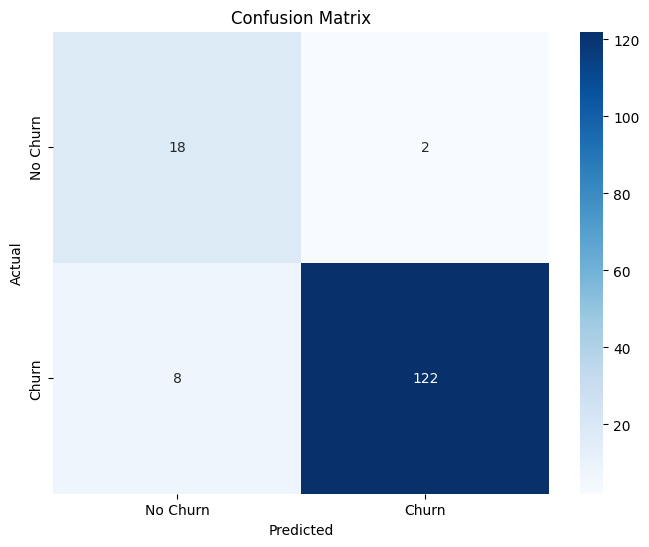

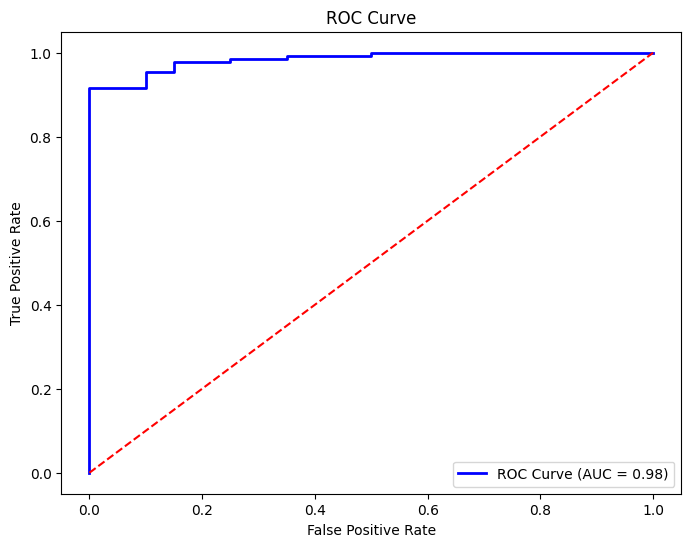

In [10]:
# Visualize the data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
